## Indexing

In [1]:
cd /home/rakesh/Downloads/Evertz/WeatherRAG

/home/rakesh/Downloads/Evertz/WeatherRAG


/home/rakesh/Downloads/Evertz/WeatherRAG/venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import torch
import time
import os
from api_keys import GROQ_API_KEY, TAVILY_API_KEY
from transformers import AutoTokenizer, AutoModel
from langchain_core.documents import Document
from langchain_elasticsearch import ElasticsearchStore
from langchain_groq import ChatGroq
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_community.tools import TavilySearchResults
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

/home/rakesh/Downloads/Evertz/WeatherRAG/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rakesh/Downloads/Evertz/WeatherRAG/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [4]:
data = pd.read_excel('data/data.xlsx')
data

,city,temperature,weather,climate
0,New York,22,sunny,temperate
1,Los Angeles,25,partly cloudy,mediterranean
2,Chicago,18,cloudy,continental
3,Houston,30,thunderstorms,humid subtropical
4,Phoenix,35,sunny,desert
5,Toronto,20,partly cloudy,continental
6,Warsaw,16,overcast,temperate
7,Bangalore,28,rainy,tropical savanna
8,London,18,drizzle,temperate maritime
9,Paris,21,partly sunny,temperate


In [5]:
data['weather_climate_desc'] = data.apply(lambda row: f"Weather is {row['weather']} and Climate is {row['climate']}", axis=1)
data

,city,temperature,weather,climate,weather_climate_desc
0,New York,22,sunny,temperate,Weather is sunny and Climate is temperate
1,Los Angeles,25,partly cloudy,mediterranean,Weather is partly cloudy and Climate is medite...
2,Chicago,18,cloudy,continental,Weather is cloudy and Climate is continental
3,Houston,30,thunderstorms,humid subtropical,Weather is thunderstorms and Climate is humid ...
4,Phoenix,35,sunny,desert,Weather is sunny and Climate is desert
5,Toronto,20,partly cloudy,continental,Weather is partly cloudy and Climate is contin...
6,Warsaw,16,overcast,temperate,Weather is overcast and Climate is temperate
7,Bangalore,28,rainy,tropical savanna,Weather is rainy and Climate is tropical savanna
8,London,18,drizzle,temperate maritime,Weather is drizzle and Climate is temperate ma...
9,Paris,21,partly sunny,temperate,Weather is partly sunny and Climate is temperate


In [6]:
docs = []
for i, row in data.iterrows():
    doc = Document(page_content=row['weather_climate_desc'], metadata={'city': row['city'], 'temperature': row['temperature'],
                                                                       'weather': row['weather'], 'climate': row['climate']})
    docs.append(doc)

In [7]:
docs

[Document(metadata={'city': 'New York', 'temperature': 22, 'weather': 'sunny', 'climate': 'temperate'}, page_content='Weather is sunny and Climate is temperate'),
 Document(metadata={'city': 'Los Angeles', 'temperature': 25, 'weather': 'partly cloudy', 'climate': 'mediterranean'}, page_content='Weather is partly cloudy and Climate is mediterranean'),
 Document(metadata={'city': 'Chicago', 'temperature': 18, 'weather': 'cloudy', 'climate': 'continental'}, page_content='Weather is cloudy and Climate is continental'),
 Document(metadata={'city': 'Houston', 'temperature': 30, 'weather': 'thunderstorms', 'climate': 'humid subtropical'}, page_content='Weather is thunderstorms and Climate is humid subtropical'),
 Document(metadata={'city': 'Phoenix', 'temperature': 35, 'weather': 'sunny', 'climate': 'desert'}, page_content='Weather is sunny and Climate is desert'),
 Document(metadata={'city': 'Toronto', 'temperature': 20, 'weather': 'partly cloudy', 'climate': 'continental'}, page_content='We

In [8]:
class CustomEmbeddingModel:
    
    def __init__(self, model_name='sentence-transformers/all-MiniLM-L6-v2'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

    def embed_text(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().tolist()
    
    def embed_query(self, query):
        return self.embed_text(query)

    def embed_documents(self, documents):
        return [self.embed_text(doc) for doc in documents]
    
embedding_model = CustomEmbeddingModel()

In [10]:
%%time

ElasticsearchStore.from_documents(docs, embedding_model,
                                  index_name="weather_rag", es_url="http://localhost:9200")

CPU times: user 796 ms, sys: 4.18 ms, total: 801 ms
Wall time: 332 ms


## Retrieval

In [9]:
# llm = ChatGroq(model="llama-3.1-70b-versatile", temperature=0)
llm = ChatGroq(model="llama-3.2-90b-text-preview", temperature=0)
# llm = ChatGroq(model="llama-3.2-90b-vision-preview", temperature=0)

In [10]:
doc_content_info = "Weather and climate of the city"

metadata_field_info = [
    AttributeInfo(name="city", description="The name of the city", type="string"),
    AttributeInfo(name="temperature", description="The temperature of the city", type="integer"),
    AttributeInfo(name="weather", description="The weather of the city", type="string"),
    AttributeInfo(name="climate", description="The climate of the city", type="string")
]

In [11]:
vectorstore = ElasticsearchStore.from_documents([], embedding_model,
                                                index_name="weather_rag", es_url="http://localhost:9200")

In [12]:
retriever = SelfQueryRetriever.from_llm(llm, vectorstore, doc_content_info,
                                        metadata_field_info, verbose=True)

In [13]:
%%time
response = retriever.invoke("What's the temperature in London?")
response

CPU times: user 142 ms, sys: 22.7 ms, total: 165 ms
Wall time: 1.67 s


[Document(metadata={'city': 'London', 'temperature': 18, 'weather': 'drizzle', 'climate': 'temperate maritime'}, page_content='Weather is drizzle and Climate is temperate maritime')]

In [14]:
%%time

for city in data['city']:
    print()
    print(city)
    t1 = time.time()
    q = f"What's the temperature in {city}?"
    response = retriever.invoke(q)
    t2 = time.time()
    print(response)
    print('Time taken:', round(t2-t1, 2), 'sec')


New York
[Document(metadata={'city': 'New York', 'temperature': 22, 'weather': 'sunny', 'climate': 'temperate'}, page_content='Weather is sunny and Climate is temperate')]
Time taken: 0.79 sec

Los Angeles
[Document(metadata={'city': 'Los Angeles', 'temperature': 25, 'weather': 'partly cloudy', 'climate': 'mediterranean'}, page_content='Weather is partly cloudy and Climate is mediterranean')]
Time taken: 0.83 sec

Chicago
[Document(metadata={'city': 'Chicago', 'temperature': 18, 'weather': 'cloudy', 'climate': 'continental'}, page_content='Weather is cloudy and Climate is continental')]
Time taken: 0.92 sec

Houston
[Document(metadata={'city': 'Houston', 'temperature': 30, 'weather': 'thunderstorms', 'climate': 'humid subtropical'}, page_content='Weather is thunderstorms and Climate is humid subtropical')]
Time taken: 0.92 sec

Phoenix
[Document(metadata={'city': 'Phoenix', 'temperature': 35, 'weather': 'sunny', 'climate': 'desert'}, page_content='Weather is sunny and Climate is deser

In [15]:
%%time
response = retriever.invoke("What's the temperature in Johannesburg?")
response

CPU times: user 139 ms, sys: 347 μs, total: 139 ms
Wall time: 2.57 s


[Document(metadata={'city': 'Johannesburg', 'temperature': 20, 'weather': 'partly sunny', 'climate': 'subtropical highland'}, page_content='Weather is partly sunny and Climate is subtropical highland')]

In [16]:
%%time
response = retriever.invoke("What's the temperature in Fort Worth?")
response

CPU times: user 136 ms, sys: 1.87 ms, total: 138 ms
Wall time: 1.28 s


[]

## RAG-Graph Components

In [17]:
decomposition_system_prompt = """
You are a helpful assistant that prepares queries that will be sent to a search component.
Sometimes, these queries are very complex.
Your job is to simplify complex queries into multiple queries that can be answered
in isolation to each other. While outputting, just output the decomposed queries separated by '\n'.

If the query is simple, then keep it as it is.
Examples
1. Query: Did Microsoft or Google make more money last year?
   Decomposed Queries: How much profit did Microsoft make last year?\nHow much profit did Google make last year?
2. Query: What is the capital of France?
   Decomposed Queries: What is the capital of France?
3. Query: What are the names of the top 10 richest people?
   Decomposed Queries: What are the names of the top 10 richest people?
4. Query: Which cities have sunny weather?
   Decomposed Queries: Which cities have sunny weather?
"""

decomposition_prompt = ChatPromptTemplate.from_messages(
    [("system", decomposition_system_prompt), 
     ("human", "Here is the initial query: \n\n {input} \n Formulate the simpler decomposed queries.")])

query_decomposer = (decomposition_prompt | llm | StrOutputParser() | (lambda x: x.split("\n")) 
                    | (lambda x: [x_i.strip() for x_i in x]))

In [18]:
question = "What's the temperature in London?"
queries = query_decomposer.invoke({"input": question})
queries

["What's the temperature in London?"]

In [19]:
question = "Where is it hottest among Paris, New York, and Warsaw?"
queries = query_decomposer.invoke({"input": question})
queries

['What is the average temperature in Paris?',
 'What is the average temperature in New York?',
 'What is the average temperature in Warsaw?']

In [20]:
def format_docs(docs):
    formatted_docs = []
    for i, doc in enumerate(docs):
        content = doc.page_content
        if doc.metadata.get("temperature"):
            doc.metadata.update({"temperature": f"{doc.metadata["temperature"]}°C"})
        metadata = "\n".join([f"{key}: {value}" for key, value in doc.metadata.items()])
        formatted_docs.append(f"Context {i+1}:-\nContent: {content}\nMetadata: {metadata}")
        
    res = "\n\n".join(doc for doc in formatted_docs)
    return res

In [21]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(description="Documents are relevant to the question - 'yes' or 'no'")

structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [22]:
grader_system_prompt = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Be slightly generous. Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [("system", grader_system_prompt),
     ("human", "Retrieved document: \n\n {document} \n\n User question: {input}")])

retrieval_grader = grade_prompt | structured_llm_grader

In [23]:
question = "What's the temperature in Johannesburg?"
docs = retriever.get_relevant_documents(question)
print(retrieval_grader.invoke({"input": question, "document": format_docs(docs)}))

/tmp/ipykernel_35333/635362467.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


binary_score='yes'


In [24]:
question = "What's the temperature in Fort Worth?"
docs = retriever.get_relevant_documents(question)
print(retrieval_grader.invoke({"input": question, "document": format_docs(docs)}))

binary_score='no'


In [25]:
web_search_tool = TavilySearchResults(max_results=5, include_answer=True)

In [26]:
rewrite_system_prompt = """You are a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning. While outputting, just output the improved query"""

rewrite_prompt = ChatPromptTemplate.from_messages(
    [("system", rewrite_system_prompt),
     ("human", "Here is the initial question: \n\n {input} \n Formulate an improved question.")])

query_rewriter_for_search = rewrite_prompt | llm | StrOutputParser()

question = "What's the temperature in Fort Worth?"
question_modified = query_rewriter_for_search.invoke({"input": question})
print(question_modified)

Current temperature in Fort Worth, Texas today


In [27]:
docs = web_search_tool.invoke({"query": question})
web_results = "\n".join([d["content"] for d in docs])
web_results = Document(page_content=web_results)
# documents.append(web_results)

In [28]:
web_results

Document(metadata={}, page_content="NWS Fort Worth/Dallas. Hot and Dry October! A Flood Watch is in effect through 12 pm Sunday for a few of our Red River counties. A complex of thunderstorms will bring heavy rainfall tonight through Sunday morning. Average rainfall totals will be between 2 to 3 inches, with isolated amounts near 4 to 5 inches in the watch area.\nToday's and tonight's Fort Worth, TX weather forecast, weather conditions and Doppler radar from The Weather Channel and Weather.com\nCurrent weather in Fort Worth, TX. Check current conditions in Fort Worth, TX with radar, hourly, and more.\nWeather Today for Fort Worth, TX | AccuWeather ### Hurricane Tracker### Severe Weather### Radar & Maps### News### Video### Winter Center 1 hour ago Severe Weather Severe storms to rattle central US this weekend through Election Day 1 hour ago Astronomy November touts 3 meteor showers, final supermoon of 2024 1 day ago Weather News When will daylight saving time end for good? 20 hours ago 

In [29]:
### Answer Grader
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""
    binary_score: str = Field(description="Answer addresses the question - 'yes' or 'no'")

structured_llm_grader = llm.with_structured_output(GradeAnswer)

In [30]:
answer_grader_system_prompt = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Be a generous grader. Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

answer_prompt = ChatPromptTemplate.from_messages(
    [("system", answer_grader_system_prompt),
     ("human", "User question: \n\n {input} \n\n LLM generation: {generation}")])

answer_grader = answer_prompt | structured_llm_grader

In [31]:
question = "What's the temperature in Fort Worth?"
generation = "The current temperature in Fort Worth, Texas is not provided in the given context. However,\
it does provide the low and high temperatures for the day. The low temperature overnight is 61°F and the high temperature for Thursday is 76°F."
print(answer_grader.invoke({"input": question, "generation": generation}))

binary_score='yes'


In [32]:
question = "What's the temperature in Fort Worth?"
generation = "The current temperature in Fort Worth, Texas is not provided in the given context."
print(answer_grader.invoke({"input": question, "generation": generation}))

binary_score='no'


In [33]:
rewrite_system_prompt = """You are a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval and highly context-rich. Look at the input and try to reason about the underlying semantic intent / meaning. \n
     While outputting, just output the improved query"""

rewrite_prompt = ChatPromptTemplate.from_messages(
    [("system", rewrite_system_prompt),
     ("human", "Here is the initial question: \n\n {input} \n Formulate an improved question.")])

query_rewriter = rewrite_prompt | llm | StrOutputParser()

In [34]:
question = "What's the temperature in Fort Worth?"
question_modified = query_rewriter.invoke({"input": question})
print(question_modified)

What is the current temperature in Fort Worth, Texas, USA?


In [35]:
conversational_flow_prompt = """You are an AI coversational assistant. Given chat_history, \
user query and candidate answer, check if the candidate answer is able to maintain the conversational flow. \
If YES, return the answer as it is. \
If NO, rephrase the candidate answer to more suit the query and the chat_history such that the conversation \
seems more fluid and natural. Also, ensure that the rephrased answer is more independent \
and does not include references to the past history. \
DO NOT add anything new in the answer, just return it as it is or rephrase it to align \
more with the conversation if needed. While outputting, just output the actual/rephrased answer.

Chat History: {chat_history}
User Query: {input}
Candidate Answer: {candidate_answer}
Answer:
"""

conversational_flow_prompt = ChatPromptTemplate.from_template(conversational_flow_prompt)

conversation_aligner = conversational_flow_prompt | llm | StrOutputParser()

In [36]:
chat_history = ["What's the temperature in London?",
                'The temperature in London is 18°C.',
                "What's the temperature in Fort Worth?",
                'The temperature in Fort Worth is 75.0°F (23.9°C).',
                'Which cities have temperate climate?',
                'Cities with a temperate climate include Paris, New York, and Warsaw.']

input = 'Where is it hottest?',
candidate_answer = 'Based on the given context, the hottest place among the given options is New York with an average temperature of 22°C.'

conversation_aligner.invoke({"input": input, "chat_history": chat_history, "candidate_answer": candidate_answer})

'New York is the hottest among the given options with an average temperature of 22°C.'

In [37]:
contextualize_q_prompt = """You are a query reformulator who, given a chat history and \
the latest user query, first thinks and checks \
if the user query doen't contain any references to past history and hence can be answered as an independent query. \
If YES, just return it as it is. \
If NO, reformulate it into a standalone query with the coreferences \
resolved, such that it can be understood without the chat history. \
DO NOT answer the query, just return it as is or reformulate it into standalone query if needed. \
While outputting, just output the actual/reformulated query.

Chat History: {chat_history}
User Query: {input}
Reformulated Query:
"""

contextualize_q_prompt = ChatPromptTemplate.from_template(contextualize_q_prompt)

history_aware_query_reformulator = contextualize_q_prompt | llm | StrOutputParser()

In [38]:
chat_history = ["What's the temperature in London?",
                'The temperature in London is 18°C.',
                "What's the temperature in Fort Worth?",
                'The temperature in Fort Worth is 75.0°F (23.9°C).',
                'Which cities have temperate climate?',
                'Cities with a temperate climate include Paris, New York, and Warsaw.',
                'Where is it hottest?',
                'New York is the hottest among the mentioned cities, with a current temperature of 22°C.']

query = "Where is it raining?"
history_aware_query_reformulator.invoke({"input": query, "chat_history": chat_history})

'Where is it raining?'

## Generation

In [39]:
template = """Answer the question based only on the following context. Don't try to make up an answer.
{context}

Question: {question}
"""

prompt = ChatPromptTemplate(messages=[template])
print(prompt.messages[0])

prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="Answer the question based only on the following context. Don't try to make up an answer.\n{context}\n\nQuestion: {question}\n") additional_kwargs={}


In [40]:
def format_docs(docs):
    formatted_docs = []
    for i, doc in enumerate(docs):
        content = doc.page_content
        doc.metadata.update({"temperature": f"{doc.metadata["temperature"]}°C"})
        metadata = "\n".join([f"{key}: {value}" for key, value in doc.metadata.items()])
        formatted_docs.append(f"Context {i+1}:-\nContent: {content}\nMetadata: {metadata}")
        
    res = "\n\n".join(doc for doc in formatted_docs)
    return res

In [41]:
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [42]:
%%time

result = rag_chain.invoke("What's the temperature in London?")
result

CPU times: user 105 ms, sys: 2.18 ms, total: 107 ms
Wall time: 1.7 s


'The temperature in London is 18°C.'

In [43]:
rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain_with_source = RunnableParallel({"context": retriever,
                                          "question": RunnablePassthrough()}
                                        ).assign(answer=rag_chain_from_docs)

In [44]:
%%time

result = rag_chain_with_source.invoke("What's the temperature in London?")
result

CPU times: user 91.3 ms, sys: 2.15 ms, total: 93.5 ms
Wall time: 1.52 s


{'context': [Document(metadata={'city': 'London', 'temperature': '18°C', 'weather': 'drizzle', 'climate': 'temperate maritime'}, page_content='Weather is drizzle and Climate is temperate maritime')],
 'question': "What's the temperature in London?",
 'answer': 'The temperature in London is 18°C.'}

In [45]:
%%time

result = rag_chain_with_source.invoke("What's the temperature in Fort Worth?")
result

CPU times: user 110 ms, sys: 1.95 ms, total: 112 ms
Wall time: 1.94 s


{'context': [],
 'question': "What's the temperature in Fort Worth?",
 'answer': "I don't have any information about the temperature in Fort Worth."}

In [46]:
%%time

result = rag_chain_with_source.invoke("Which cities have temperate climate?")
result

CPU times: user 89.6 ms, sys: 5.02 ms, total: 94.7 ms
Wall time: 1.53 s


{'context': [Document(metadata={'city': 'Paris', 'temperature': '21°C', 'weather': 'partly sunny', 'climate': 'temperate'}, page_content='Weather is partly sunny and Climate is temperate'),
  Document(metadata={'city': 'New York', 'temperature': '22°C', 'weather': 'sunny', 'climate': 'temperate'}, page_content='Weather is sunny and Climate is temperate'),
  Document(metadata={'city': 'Warsaw', 'temperature': '16°C', 'weather': 'overcast', 'climate': 'temperate'}, page_content='Weather is overcast and Climate is temperate')],
 'question': 'Which cities have temperate climate?',
 'answer': 'Based on the given context, the cities with a temperate climate are:\n\n1. Paris\n2. New York\n3. Warsaw'}

In [47]:
print(result['answer'])

Based on the given context, the cities with a temperate climate are:

1. Paris
2. New York
3. Warsaw


In [48]:
%%time

result = rag_chain_with_source.invoke("Where is it hottest?")
result

CPU times: user 98.8 ms, sys: 1.36 ms, total: 100 ms
Wall time: 1.62 s


{'context': [Document(metadata={'city': 'Beijing', 'temperature': '24°C', 'weather': 'smoggy', 'climate': 'continental'}, page_content='Weather is smoggy and Climate is continental'),
  Document(metadata={'city': 'Rio de Janeiro', 'temperature': '29°C', 'weather': 'scattered showers', 'climate': 'tropical'}, page_content='Weather is scattered showers and Climate is tropical'),
  Document(metadata={'city': 'Johannesburg', 'temperature': '20°C', 'weather': 'partly sunny', 'climate': 'subtropical highland'}, page_content='Weather is partly sunny and Climate is subtropical highland'),
  Document(metadata={'city': 'Bangalore', 'temperature': '28°C', 'weather': 'rainy', 'climate': 'tropical savanna'}, page_content='Weather is rainy and Climate is tropical savanna')],
 'question': 'Where is it hottest?',
 'answer': 'Based on the given context, it is hottest in Rio de Janeiro with a temperature of 29°C.'}

## RAG-Graph

In [49]:
template = """Answer the question based only on the following context. Don't try to make up an answer.
{context}

Question: {input}
"""

prompt = ChatPromptTemplate(messages=[template])
print(prompt.messages[0])

prompt=PromptTemplate(input_variables=['context', 'input'], input_types={}, partial_variables={}, template="Answer the question based only on the following context. Don't try to make up an answer.\n{context}\n\nQuestion: {input}\n") additional_kwargs={}


In [50]:
def format_docs(docs):
    formatted_docs = []
    for i, doc in enumerate(docs):
        content = doc.page_content
        if doc.metadata.get("temperature"):
            doc.metadata.update({"temperature": f"{doc.metadata["temperature"]}°C"})
        metadata = "\n".join([f"{key}: {value}" for key, value in doc.metadata.items()])
        formatted_docs.append(f"Context {i+1}:-\nContent: {content}\nMetadata: {metadata}")
        
    res = "\n\n".join(doc for doc in formatted_docs)
    return res

In [51]:
rag_chain = (RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"]))) 
             | prompt | llm | StrOutputParser())

In [52]:
question = "What's the temperature in London?"

In [53]:
documents = retriever.get_relevant_documents(question)
documents

[Document(metadata={'city': 'London', 'temperature': 18, 'weather': 'drizzle', 'climate': 'temperate maritime'}, page_content='Weather is drizzle and Climate is temperate maritime')]

In [54]:
generation = rag_chain.invoke({"context": documents, "input": question})
generation

'The temperature in London is 18°C.'

In [55]:
def retrieve(state):
    print("---RETRIEVE---")
    inp = state["input"]

    try:
        documents = retriever.get_relevant_documents(inp)
        return {"documents": documents, "input": inp, "retriever_exception": False}
    except:
        return {"documents": [], "input": inp, "retriever_exception": True}

In [56]:
def decide_to_rewrite(state):
    print("---CHECK RETRIEVER FOR EXCEPTION---")
    retriever_exception = state["retriever_exception"]

    if retriever_exception:
        print("---DECISION: EXCEPTION OCCURRED! REWRITE QUERY---")
        return "exception"
    else:
        print("---DECISION: NO EXCEPTION! GRADE DOCUMENTS---")
        return "grade_documents"

In [57]:
def rewrite_query(state):
    print("---REWRITE QUERY---")
    inp = state["input"]
    documents = state["documents"]

    query_rewritten = query_rewriter.invoke({"input": inp})
    print(f"---modified_query: {query_rewritten}---")
    return {"documents": documents, "input": query_rewritten}

In [58]:
def generate(state):
    print("---GENERATE---")
    inp = state["input"]
    documents = state["documents"]

    generation = rag_chain.invoke({"context": documents, "input": inp})
    return {"documents": documents, "input": inp, "generation": generation}

In [59]:
def grade_documents(state):
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    inp = state["input"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for doc in documents:
        score = retrieval_grader.invoke({"input": inp, "document": format_docs([doc])})
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(doc)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")

    web_search = "No" if filtered_docs else "Yes"
    return {"documents": filtered_docs, "input": inp, "web_search": web_search}

In [60]:
def web_search(state):
    print("---WEB SEARCH---")
    inp = state["input"]
    documents = state["documents"]

    # Re-write query
    query_rewritten = query_rewriter_for_search.invoke({"input": inp})
    print(f"---modified_query: {query_rewritten}---")

    # Web search
    docs = web_search_tool.invoke({"query": query_rewritten})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "input": query_rewritten}

In [61]:
def decide_to_generate(state):
    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]

    if web_search == "Yes":
        print("---DECISION: NONE OF THE DOCUMENTS ARE RELEVANT TO QUERY, WEB SEARCH---")
        return "web_search"
    else:
        print("---DECISION: GENERATE---")
        return "generate"

In [62]:
def grade_generation_if_answers_question(state):
    print("---CHECK WHETHER GENERATION ANSWERS QUESTION---")
    inp = state["input"]
    generation = state["generation"]

    score = answer_grader.invoke({"input": inp, "generation": generation})
    grade = score.binary_score
    if grade == "yes":
        print("---DECISION: GENERATION ANSWERS QUESTION---")
        return "useful"
    else:
        print("---DECISION: GENERATION DOES NOT ANSWERS QUESTION---")
        return "not_useful"

In [63]:
class GraphState(TypedDict):
    """ Represents the state of our graph. """
    input: str
    retriever_exception: bool
    generation: str
    web_search: str
    documents: List[str]

workflow = StateGraph(GraphState)

In [64]:
# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("rewrite_query", rewrite_query)  # rewrite_query
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("web_search_node", web_search)  # web search
workflow.add_node("generate", generate)  # generate

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_conditional_edges(
    "retrieve", decide_to_rewrite,
    {"exception": "rewrite_query", "grade_documents": "grade_documents"})
workflow.add_conditional_edges(
    "grade_documents", decide_to_generate,
    {"web_search": "web_search_node", "generate": "generate"})
workflow.add_edge("web_search_node", "generate")
workflow.add_conditional_edges(
    "generate", grade_generation_if_answers_question,
    {"useful": END, "not_useful": "rewrite_query"})
workflow.add_edge("rewrite_query", "retrieve")

# Compile
app = workflow.compile()

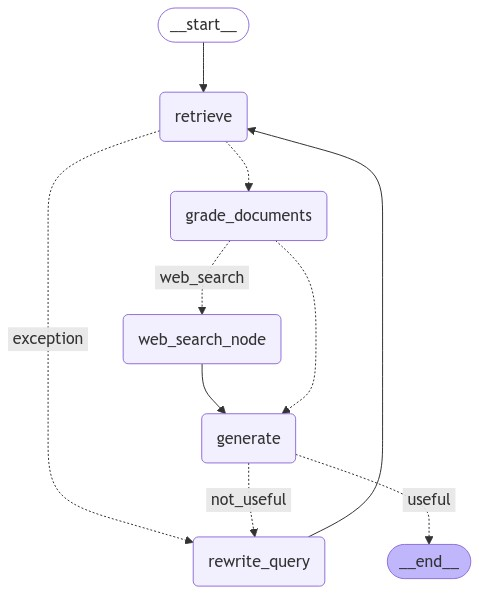

In [65]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [66]:
rag_chain_main = prompt | llm | StrOutputParser()

In [67]:
def reformulate_query_using_history(state):
    print("---REFORMULATE QUERY USING HISTORY---")
    inp = state["input"]
    chat_history = state["chat_history"]

    if chat_history:
        reformulated_query = history_aware_query_reformulator.invoke({"input": inp, "chat_history": chat_history})
    else:
        reformulated_query = inp
        
    print(f"---reformulated_query: {reformulated_query}--")
    return {"input": inp, "chat_history": chat_history, "reformulated_query": reformulated_query}

In [68]:
def decompose_query(state):
    print("---DECOMPOSE QUERY---")
    reformulated_query = state["reformulated_query"]

    sub_queries = query_decomposer.invoke({"input": reformulated_query})
    print(f"---decomposed_queries: {sub_queries}--")
    return {"input": reformulated_query, "sub_queries": sub_queries}

In [69]:
def answer_sub_queries(state):
    print("---ANSWER SUB-QUERIES---")
    sub_queries = state["sub_queries"]

    sub_answers = []
    for sub_query in sub_queries:
        sub_answer = app.invoke({"input": sub_query})
        sub_answers.append(sub_answer)

    return {"sub_queries": sub_queries, "sub_answers": sub_answers}

In [70]:
def answer_query(state):
    print("---ANSWER QUERY---")
    reformulated_query = state["reformulated_query"]
    sub_answers = state["sub_answers"]

    answer = rag_chain_main.invoke({"context": sub_answers, "input": reformulated_query})
    return {"input": reformulated_query, "sub_answers": sub_answers, "candidate_answer": answer}

In [71]:
def maintain_conversational_flow(state):
    print("---MAINTAIN CONVERSATIONAL FLOW---")
    chat_history = state["chat_history"]
    inp = state["input"]
    candidate_answer = state["candidate_answer"]

    answer = conversation_aligner.invoke({"chat_history": chat_history, "input": inp, "candidate_answer": candidate_answer})
    return {"input": inp, "chat_history": chat_history, "candidate_answer": candidate_answer, "answer": answer}

In [72]:
class GraphStateMain(TypedDict):
    """ Represents the state of our graph. """
    input: str
    chat_history: List[str]
    reformulated_query: str
    sub_queries: List[str]
    sub_answers: List[str]
    candidate_answer: str
    answer: str

workflow_main = StateGraph(GraphStateMain)

In [73]:
# Define the nodes
workflow_main.add_node("reformulate_query_using_history", reformulate_query_using_history)  # reformulate query using history
workflow_main.add_node("decompose_query", decompose_query)  # decompose query
workflow_main.add_node("answer_sub_queries", answer_sub_queries)  # answer sub-queries
workflow_main.add_node("answer_query", answer_query)  # answer query
workflow_main.add_node("maintain_conversational_flow", maintain_conversational_flow)  # maintain conversational flow

# Build graph
workflow_main.add_edge(START, "reformulate_query_using_history")
workflow_main.add_edge("reformulate_query_using_history", "decompose_query")
workflow_main.add_edge("decompose_query", "answer_sub_queries")
workflow_main.add_edge("answer_sub_queries", "answer_query")
workflow_main.add_edge("answer_query", "maintain_conversational_flow")
workflow_main.add_edge("maintain_conversational_flow", END)

# Compile
app_main = workflow_main.compile()

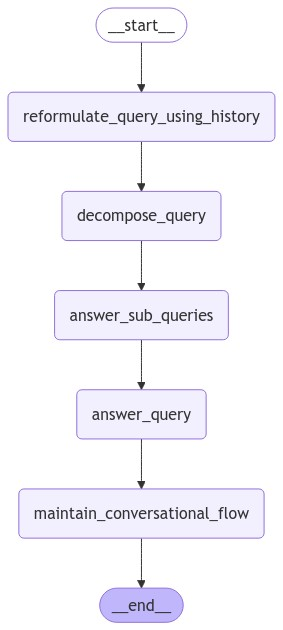

In [74]:
display(
    Image(
        app_main.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [75]:
chat_history = []

In [76]:
%%time
query = "What's the temperature in London?"
res = app_main.invoke({"input": query, "chat_history": chat_history})
chat_history += [query, res['answer']]
res

---REFORMULATE QUERY USING HISTORY---
---reformulated_query: What's the temperature in London?--
---DECOMPOSE QUERY---
---decomposed_queries: ["What's the temperature in London?"]--
---ANSWER SUB-QUERIES---
---RETRIEVE---
---CHECK RETRIEVER FOR EXCEPTION---
---DECISION: NO EXCEPTION! GRADE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK WHETHER GENERATION ANSWERS QUESTION---
---DECISION: GENERATION ANSWERS QUESTION---
---ANSWER QUERY---
---MAINTAIN CONVERSATIONAL FLOW---
CPU times: user 239 ms, sys: 6.75 ms, total: 245 ms
Wall time: 4.6 s


{'input': "What's the temperature in London?",
 'chat_history': ["What's the temperature in London?",
  'The temperature in London is 18°C.'],
 'reformulated_query': "What's the temperature in London?",
 'sub_queries': ["What's the temperature in London?"],
 'sub_answers': [{'input': "What's the temperature in London?",
   'retriever_exception': False,
   'generation': 'The temperature in London is 18°C.',
   'web_search': 'No',
   'documents': [Document(metadata={'city': 'London', 'temperature': '18°C°C', 'weather': 'drizzle', 'climate': 'temperate maritime'}, page_content='Weather is drizzle and Climate is temperate maritime')]}],
 'candidate_answer': 'The temperature in London is 18°C.',
 'answer': 'The temperature in London is 18°C.'}

In [77]:
chat_history

["What's the temperature in London?", 'The temperature in London is 18°C.']

In [78]:
%%time
query = "What's the temperature in Fort Worth?"
res = app_main.invoke({"input": query, "chat_history": chat_history})
chat_history += [query, res['answer']]
res

---REFORMULATE QUERY USING HISTORY---
---reformulated_query: What's the temperature in Fort Worth?--
---DECOMPOSE QUERY---
---decomposed_queries: ["What's the temperature in Fort Worth?"]--
---ANSWER SUB-QUERIES---
---RETRIEVE---
---CHECK RETRIEVER FOR EXCEPTION---
---DECISION: NO EXCEPTION! GRADE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---DECISION: NONE OF THE DOCUMENTS ARE RELEVANT TO QUERY, WEB SEARCH---
---WEB SEARCH---
---modified_query: Current temperature in Fort Worth, Texas---
---GENERATE---
---CHECK WHETHER GENERATION ANSWERS QUESTION---
---DECISION: GENERATION DOES NOT ANSWERS QUESTION---
---REWRITE QUERY---
---modified_query: What is the current weather temperature in Fort Worth, Texas, USA?---
---RETRIEVE---
---CHECK RETRIEVER FOR EXCEPTION---
---DECISION: NO EXCEPTION! GRADE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---DECISION: NONE OF THE DOCUMENTS ARE RELEVANT TO QUERY, WEB SEARCH

{'input': "What's the temperature in Fort Worth?",
 'chat_history': ["What's the temperature in London?",
  'The temperature in London is 18°C.',
  "What's the temperature in Fort Worth?",
  'The temperature in Fort Worth is 75.0°F (23.9°C).'],
 'reformulated_query': "What's the temperature in Fort Worth?",
 'sub_queries': ["What's the temperature in Fort Worth?"],
 'sub_answers': [{'input': 'Fort Worth Texas current weather temperature',
   'retriever_exception': False,
   'generation': 'The current weather temperature in Fort Worth, Texas is 75.0°F (23.9°C).',
   'web_search': 'Yes',
   'documents': [Document(metadata={}, page_content="{'location': {'name': 'Fort Worth', 'region': 'Texas', 'country': 'United States of America', 'lat': 32.7253, 'lon': -97.3206, 'tz_id': 'America/Chicago', 'localtime_epoch': 1730703434, 'localtime': '2024-11-04 00:57'}, 'current': {'last_updated_epoch': 1730702700, 'last_updated': '2024-11-04 00:45', 'temp_c': 23.9, 'temp_f': 75.0, 'is_day': 0, 'condit

In [79]:
chat_history

["What's the temperature in London?",
 'The temperature in London is 18°C.',
 "What's the temperature in Fort Worth?",
 'The temperature in Fort Worth is 75.0°F (23.9°C).']

In [80]:
%%time
query = "Which cities have temperate climate?"
res = app_main.invoke({"input": query, "chat_history": chat_history})
chat_history += [query, res['answer']]
res

---REFORMULATE QUERY USING HISTORY---
---reformulated_query: Which cities have temperate climate?--
---DECOMPOSE QUERY---
---decomposed_queries: ['What cities have a temperate climate?']--
---ANSWER SUB-QUERIES---
---RETRIEVE---
---CHECK RETRIEVER FOR EXCEPTION---
---DECISION: NO EXCEPTION! GRADE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK WHETHER GENERATION ANSWERS QUESTION---
---DECISION: GENERATION ANSWERS QUESTION---
---ANSWER QUERY---
---MAINTAIN CONVERSATIONAL FLOW---
CPU times: user 255 ms, sys: 10.4 ms, total: 265 ms
Wall time: 9.53 s


{'input': 'Which cities have temperate climate?',
 'chat_history': ["What's the temperature in London?",
  'The temperature in London is 18°C.',
  "What's the temperature in Fort Worth?",
  'The temperature in Fort Worth is 75.0°F (23.9°C).',
  'Which cities have temperate climate?',
  'Cities like Paris, New York, and Warsaw have a temperate climate.'],
 'reformulated_query': 'Which cities have temperate climate?',
 'sub_queries': ['What cities have a temperate climate?'],
 'sub_answers': [{'input': 'What cities have a temperate climate?',
   'retriever_exception': False,
   'generation': 'Based on the provided context, the cities with a temperate climate are:\n\n1. Paris\n2. New York\n3. Warsaw',
   'web_search': 'No',
   'documents': [Document(metadata={'city': 'Paris', 'temperature': '21°C°C', 'weather': 'partly sunny', 'climate': 'temperate'}, page_content='Weather is partly sunny and Climate is temperate'),
    Document(metadata={'city': 'New York', 'temperature': '22°C°C', 'weat

In [81]:
chat_history

["What's the temperature in London?",
 'The temperature in London is 18°C.',
 "What's the temperature in Fort Worth?",
 'The temperature in Fort Worth is 75.0°F (23.9°C).',
 'Which cities have temperate climate?',
 'Cities like Paris, New York, and Warsaw have a temperate climate.']

In [82]:
%%time
query = "Where is it hottest?"
res = app_main.invoke({"input": query, "chat_history": chat_history})
chat_history += [query, res['answer']]
res

---REFORMULATE QUERY USING HISTORY---
---reformulated_query: Where is it hottest among London, Fort Worth, Paris, New York, and Warsaw?--
---DECOMPOSE QUERY---
---decomposed_queries: ['What is the average temperature in London?', 'What is the average temperature in Fort Worth?', 'What is the average temperature in Paris?', 'What is the average temperature in New York?', 'What is the average temperature in Warsaw?']--
---ANSWER SUB-QUERIES---
---RETRIEVE---
---CHECK RETRIEVER FOR EXCEPTION---
---DECISION: NO EXCEPTION! GRADE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK WHETHER GENERATION ANSWERS QUESTION---
---DECISION: GENERATION ANSWERS QUESTION---
---RETRIEVE---
---CHECK RETRIEVER FOR EXCEPTION---
---DECISION: NO EXCEPTION! GRADE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---DECISION: NONE OF THE DOCUMENTS ARE RELEVANT TO 

{'input': 'Where is it hottest among London, Fort Worth, Paris, New York, and Warsaw?',
 'chat_history': ["What's the temperature in London?",
  'The temperature in London is 18°C.',
  "What's the temperature in Fort Worth?",
  'The temperature in Fort Worth is 75.0°F (23.9°C).',
  'Which cities have temperate climate?',
  'Cities like Paris, New York, and Warsaw have a temperate climate.',
  'Where is it hottest?',
  'The hottest place among the given options is Fort Worth with a temperature of 75.0°F (23.9°C).'],
 'reformulated_query': 'Where is it hottest among London, Fort Worth, Paris, New York, and Warsaw?',
 'sub_queries': ['What is the average temperature in London?',
  'What is the average temperature in Fort Worth?',
  'What is the average temperature in Paris?',
  'What is the average temperature in New York?',
  'What is the average temperature in Warsaw?'],
 'sub_answers': [{'input': 'What is the average temperature in London?',
   'retriever_exception': False,
   'generat

In [83]:
chat_history

["What's the temperature in London?",
 'The temperature in London is 18°C.',
 "What's the temperature in Fort Worth?",
 'The temperature in Fort Worth is 75.0°F (23.9°C).',
 'Which cities have temperate climate?',
 'Cities like Paris, New York, and Warsaw have a temperate climate.',
 'Where is it hottest?',
 'The hottest place among the given options is Fort Worth with a temperature of 75.0°F (23.9°C).']

In [84]:
%%time
query = "Where is it raining?"
res = app_main.invoke({"input": query, "chat_history": chat_history})
chat_history += [query, res['answer']]
res

---REFORMULATE QUERY USING HISTORY---
---reformulated_query: Where is it raining?--
---DECOMPOSE QUERY---
---decomposed_queries: ['What cities are currently experiencing rain?']--
---ANSWER SUB-QUERIES---
---RETRIEVE---
---CHECK RETRIEVER FOR EXCEPTION---
---DECISION: NO EXCEPTION! GRADE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---DECISION: NONE OF THE DOCUMENTS ARE RELEVANT TO QUERY, WEB SEARCH---
---WEB SEARCH---
---modified_query: "Current cities with rain worldwide"---
---GENERATE---
---CHECK WHETHER GENERATION ANSWERS QUESTION---
---DECISION: GENERATION ANSWERS QUESTION---
---ANSWER QUERY---
---MAINTAIN CONVERSATIONAL FLOW---
CPU times: user 262 ms, sys: 10.5 ms, total: 272 ms
Wall time: 16.4 s


{'input': 'Where is it raining?',
 'chat_history': ["What's the temperature in London?",
  'The temperature in London is 18°C.',
  "What's the temperature in Fort Worth?",
  'The temperature in Fort Worth is 75.0°F (23.9°C).',
  'Which cities have temperate climate?',
  'Cities like Paris, New York, and Warsaw have a temperate climate.',
  'Where is it hottest?',
  'The hottest place among the given options is Fort Worth with a temperature of 75.0°F (23.9°C).',
  'Where is it raining?',
  'It is raining in Wichita (Light rain).'],
 'reformulated_query': 'Where is it raining?',
 'sub_queries': ['What cities are currently experiencing rain?'],
 'sub_answers': [{'input': '"Current cities with rain worldwide"',
   'retriever_exception': False,
   'generation': 'Based on the provided context, the following cities are mentioned as having rain:\n\n1. Wichita (Light rain)\n2. Buenaventura (258 days of rain per year)\n3. Cairns (117 days of rain per year)\n4. Quibdo (holds the title of the wett

In [85]:
chat_history

["What's the temperature in London?",
 'The temperature in London is 18°C.',
 "What's the temperature in Fort Worth?",
 'The temperature in Fort Worth is 75.0°F (23.9°C).',
 'Which cities have temperate climate?',
 'Cities like Paris, New York, and Warsaw have a temperate climate.',
 'Where is it hottest?',
 'The hottest place among the given options is Fort Worth with a temperature of 75.0°F (23.9°C).',
 'Where is it raining?',
 'It is raining in Wichita (Light rain).']